In [1]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam

In [2]:
torch.manual_seed(0)
np.random.seed(0)


################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(11, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        #x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [26]:
################################################################
#  configurations
################################################################
ntrain = 1200
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 128
width = 64

In [ ]:
################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)  [2048,8192]  -->  [first 1000, :] train + [last 100, :] test
dataloader = MatReader('data/burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:,::sub] #Training at a resolution lower than 2**3=8192
y_data = dataloader.read_field('u')[:,::sub]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

In [27]:
Tin=10
T=10
step = 1

dataloader = MatReader('data/burgers_self_time.mat')
IC = (dataloader.read_field('input')).reshape(-1,1,1024)
x_data = dataloader.read_field('result')[:,1:Tin,:]
y_data = dataloader.read_field('result')[:,Tin:,:]

x_train = x_data[:ntrain,:,:]
x_train = torch.cat((IC[:ntrain,:,:],x_train),dim=1)
y_train = y_data[:ntrain,:,:]
x_test = x_data[-ntest:,:,:]
x_test = torch.cat((IC[-ntest:,:,:],x_test),dim=1)
y_test = y_data[-ntest:,:,:]

<function matplotlib.pyplot.show(close=None, block=None)>

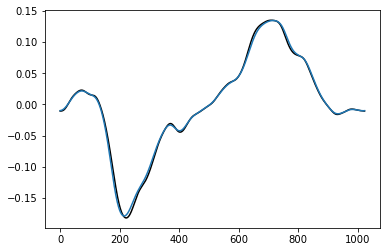

In [24]:
plt.plot(x_train[-5,:,9].cpu().numpy(),'k')

plt.plot(y_train[-5,:,9].cpu().numpy())

plt.show

In [28]:
y_train = y_train.permute(0,2,1)
y_test = y_test.permute(0,2,1)

x_train = x_train.permute(0,2,1)
x_test = x_test.permute(0,2,1)

In [29]:
y_train.shape

torch.Size([1200, 1024, 10])

In [30]:
#x_train = x_train.reshape(ntrain,s,Tin)
#x_test = x_test.reshape(ntest,s,Tin)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

4220161


In [ ]:
y.reshape(batch_size, -1).shape

In [ ]:
yy[..., t:t+step].shape

In [ ]:
out.shape

In [ ]:
xx.shape
#out.shape

torch.cat((xx[..., 1:],out),dim=-1).shape

In [31]:
################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_full = 0
    train_l2 = 0
    j=1
    for xx, yy in train_loader:
        loss = 0
        xx, yy = xx.cuda(), yy.cuda()
        
        for t in range(0,T,step):
            #print('it enters')
            y = yy[..., t:t+step]
            out = model(xx)
            loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))
            #print('it reaches')
            
            if t == 0:
                pred = out
            else:
                pred = torch.cat((pred, out), -1)
                
            xx = torch.cat((xx[..., step:],out),dim=-1)

        optimizer.zero_grad()
        #mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        #l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        loss.backward() # use the l2 relative loss
        optimizer.step()
                           
                           
        #train_mse += mse.item()
        train_l2 += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

    scheduler.step()
    model.eval()
    test_l2 = 0
    test_l2_full = 0
    j=1
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx, yy = xx.cuda(), yy.cuda()
        
            for t in range(0,T,step):
                #print('test')
                y = yy[..., t:t+step]
                out = model(xx)
                loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))
            
                if t == 0:
                    pred = out
                else:
                    pred = torch.cat((pred, out), -1)
                
                xx = torch.cat((xx[..., step:],out),dim=-1)
                           
            #test_mse += mse.item()
            test_l2 += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()
                               
    t2 = default_timer()
    print(ep, t2-t1, train_l2_full, test_l2_full)


#pred = torch.zeros(y_test.shape)
#index = 0
#test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
#with torch.no_grad():
#    for x, y in test_loader:
#        test_l2 = 0
#        x, y = x.cuda(), y.cuda()

#        out = model(x).view(-1)
#        pred[index] = out

#        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
#        print(index, test_l2)
#        index = index + 1

#scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})


0 7.943599023856223 305.1885697245598 4.460280060768127
1 8.05219459021464 63.23905697464943 3.9741745591163635
2 7.769487667828798 39.589589431881905 1.3783239871263504
3 7.578238148242235 30.45885941386223 2.4842540621757507
4 7.555832447018474 35.12895378470421 1.9769995510578156
5 7.555584444198757 26.536867275834084 2.1732627153396606
6 7.55424875812605 26.936987683176994 1.5938917696475983
7 7.556251355912536 26.845876798033714 2.6051456928253174
8 7.555611957795918 26.753359645605087 2.4788533449172974
9 7.551443501841277 25.27548386156559 2.8957969546318054
10 7.5531847900711 23.440879300236702 2.4321474730968475
11 7.556020135991275 25.07617437839508 2.679676651954651
12 7.557148524560034 22.795184306800365 1.7840751111507416
13 7.590549661777914 21.23285685479641 1.5748647153377533
14 7.702409354969859 28.530423678457737 2.5770875811576843
15 7.799080195836723 21.091275572776794 1.985486090183258
16 7.754247664939612 21.623502552509308 2.38387393951416
17 7.7725607408210635 2

140 7.937456248793751 3.82483933493495 0.3880099281668663
141 7.9203849751502275 4.1997387036681175 0.42735785245895386
142 7.925123258959502 3.8637874983251095 0.39748483896255493
143 7.919432266615331 3.715961132198572 0.391934871673584
144 7.919367189053446 4.302687913179398 0.3314276561141014
145 7.919881454668939 3.453159859403968 0.47365761548280716
146 7.924295995384455 3.8545832745730877 0.2842521108686924
147 7.922633870039135 3.377110818400979 0.27365510910749435
148 7.919647401198745 2.632588230073452 0.18439897522330284
149 7.922748733777553 3.50181289575994 0.2080022357404232
150 7.924800592940301 1.3350437013432384 0.11813234351575375
151 7.92232962930575 1.5015428764745593 0.14648267813026905
152 7.881561274174601 1.9488886389881372 0.17991435155272484
153 7.828865610994399 1.9277829863131046 0.20434438809752464
154 7.86939945910126 1.9654758293181658 0.06898556090891361
155 8.069922989234328 1.610322393476963 0.13594085536897182
156 8.013732067774981 1.581844831816852 0

275 7.900016705039889 0.4371536932885647 0.028660006821155548
276 7.909215515013784 0.35298880166374147 0.03034431580454111
277 7.9002058557234704 0.43651154125109315 0.06843522749841213
278 7.896987863816321 0.4889892227947712 0.04604812990874052
279 7.897974515799433 0.4036952252499759 0.030405890196561813
280 7.902652474120259 0.4241567621938884 0.029679778032004833
281 7.898289113305509 0.5252048838883638 0.029869289603084326
282 7.892080116085708 0.4178993203677237 0.0488602165132761
283 7.901293880771846 0.5404344405978918 0.02568572713062167
284 7.901301728095859 0.359588211402297 0.04361855238676071
285 7.903434276115149 0.3887469321489334 0.03780388506129384
286 7.894718608818948 0.38939807610586286 0.03497809590771794
287 7.900467220693827 0.5999619187787175 0.05584836099296808
288 7.900978342164308 0.48429616540670395 0.051200409419834614
289 7.899269428104162 0.5868387497030199 0.04531134385615587
290 7.901739701163024 0.592293550260365 0.040300955064594746
291 7.9048719960

407 7.912862201221287 0.1975225501228124 0.018024395452812314
408 7.916358522605151 0.1987458395306021 0.01855638949200511
409 7.915400041267276 0.20117521448992193 0.01872451463714242
410 7.91626150207594 0.1984666809439659 0.018725153524428606
411 7.91738409223035 0.19924669852480292 0.018246852792799473
412 7.927611439023167 0.19861452304758132 0.018327060621231794
413 7.924559369217604 0.19903642195276916 0.018558898475021124
414 7.919131008908153 0.20211330172605813 0.019187067169696093
415 7.914690522942692 0.20354964188300073 0.018497402546927333
416 7.911393141839653 0.198336185188964 0.01864852919243276
417 7.914996152743697 0.2023683397565037 0.018102047499269247
418 7.915272224228829 0.19637951883487403 0.01938648335635662
419 7.912168508861214 0.20442837639711797 0.01872215373441577
420 7.91462978720665 0.19977882551029325 0.018513171933591366
421 7.913539649918675 0.1975901024416089 0.01992839272134006
422 7.912132038269192 0.20790755981579423 0.01967613399028778
423 7.913

In [32]:
pred.shape

torch.Size([20, 1024, 10])

In [40]:
torch.save(model, 'model/ns_fourier_burgers')

FileNotFoundError: [Errno 2] No such file or directory: 'model/ns_fourier_burgers'

In [ ]:
out.shape

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
x_data.shape

In [ ]:
y_test.shape

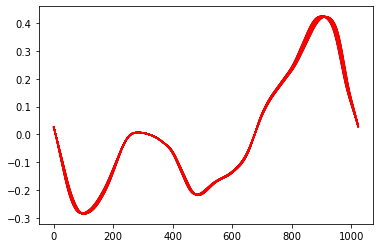

In [39]:
plt.plot(pred[-20,:].detach().cpu().numpy(),'k')

plt.plot(y_test[-20,:,:].cpu().numpy(), 'r')

plt.show()

In [ ]:
plt.plot(x_test[-1,:,:].cpu().numpy())

In [ ]:
w_cat.shape

In [ ]:
torch.cat((U[:,:,1:10],w),dim=-1).shape

# Smaller dt=0.02 - Learning

In [39]:
time = []
w = model(U[:,:,0:10])

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.93 GiB total capacity; 1.90 GiB already allocated; 22.69 MiB free; 2.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [132]:
w.shape

torch.Size([1, 1024, 1])

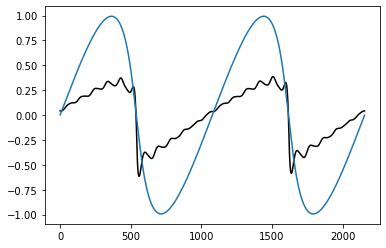

In [142]:
plt.plot(w[-1,:].detach().cpu().numpy(), 'k')
plt.plot(U[-1,:,11].cpu().numpy())
plt.show()

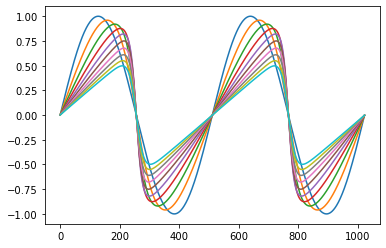

In [134]:
for i in range(0,10):
    plt.plot(U[-1,:,i].cpu().numpy())

In [119]:
U[:,:,2].shape

torch.Size([1, 1024])

<function matplotlib.pyplot.show(close=None, block=None)>

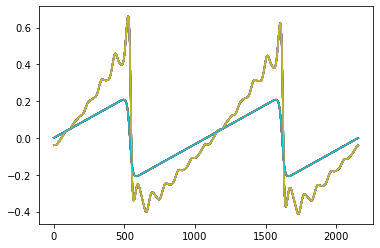

In [152]:
for i in range(0,20): #gibbs phenomenon. why?
        plt.plot(timenp[-1,:])
    #plt.plot(w[-1,:,:].cpu().detach().numpy())
        plt.plot(U[-1,:,-1].cpu().numpy())

plt.show


In [ ]:
timenp.shape

In [ ]:
plt.plot(xfield.detach().numpy(), sinfield[-1,:].cpu().detach().numpy()) #I learned with smaller dt=0.02 but it gives gibbs phenomenon
plt.plot(xfield.detach().numpy(), timenp[48,:], 'b')
plt.plot(X, U[:,49])

plt.show()

#Ok, so in this learning there was no capturing of the shock phenomenon. But still, the operator learns the correct
#direction of dynamics and when the shock starts to form, it gives gibbs phenemonon. Maybe, related to the fact
#fourier gives gibbs phenomenon when dealing with sharp functions.

# Time Plotting - dt = 1

In [ ]:
plt.plot(sinfield[-1,:].cpu().detach().numpy()) #Comparison for the first timestep
plt.plot(w[-1,:].cpu().detach().numpy(), 'b')
plt.plot(U[:,-1])

plt.show()

In [ ]:
plt.plot(sinfield[-1,:].cpu().detach().numpy()) #Comparison for the second timestep
plt.plot(timenp[1,:], 'b')
plt.plot(U[:,-1])

In [ ]:
plt.plot(sinfield[-1,:].cpu().detach().numpy()) #Comparison for the third timestep
plt.plot(timenp[2,:], 'b')
plt.plot(U[:,-1])

In [ ]:
plt.plot(sinfield[-1,:].cpu().detach().numpy()) #Comparison for the third timestep
plt.plot(timenp[3,:], 'b')
plt.plot(U[:,-1])

In [ ]:
xfield = torch.linspace(0,1,8192)
sinfield = np.sin(2*np.pi*xfield)

plt.plot(sinfield)

sinfield = sinfield.reshape(1,8192,1)
sinfield = sinfield.cuda()

In [ ]:
w = model(sinfield)

# Burgers Solution

In [34]:
############## MODULES IMPORTATION ###############
import numpy as np
from scipy.integrate import odeint


############## SET-UP THE PROBLEM ###############

mu = 1
nu = 1/1000 #kinematic viscosity coefficient
    
#Spatial mesh
L_x = 1 #Range of the domain according to x [m]
dx = 1/2156 #Infinitesimal distance
N_x = int(L_x/dx) #Points number of the spatial mesh
X = np.linspace(0,L_x,2156) #Spatial array

#Temporal mesh
L_t = 1 #Duration of simulation [s]
dt = 0.05  #Infinitesimal time
N_t = int(L_t/dt) #Points number of the temporal mesh
T = np.linspace(0,L_t,250) #Temporal array

#Wave number discretization
k = 2*np.pi*np.fft.fftfreq(N_x, d = 1/2156)


#Def of the initial condition    
u0 = np.sin(4*np.pi*(X)) #Single space variable fonction that represent the wave form at t = 0
# viz_tools.plot_a_frame_1D(X,u0,0,L_x,0,1.2,'Initial condition')

#u0 = init_data

############## EQUATION SOLVING ###############

#Definition of ODE system (PDE ---(FFT)---> ODE system)
def burg_system(u,t,k,mu,nu):
    #Spatial derivative in the Fourier domain
    u_hat = np.fft.fft(u)
    u_hat_x = 1j*k*u_hat
    u_hat_xx = -k**2*u_hat
    
    #Switching in the spatial domain
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)
    
    #ODE resolution
    u_t = -mu*u*u_x + nu*u_xx
    return u_t.real
    

#PDE resolution (ODE system resolution)
U = odeint(burg_system, u0, T, args=(k,mu,nu,), mxstep=5000).T


In [35]:
U.shape

(2156, 250)

In [36]:
U = torch.tensor(U, dtype=torch.float)
U = U.reshape(1,2156,250)
U = U.cuda()